In [1]:
import os
import re
import nltk
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# from tqdm import tqdm
# from nltk.corpus import stopwords
# from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('tweeter.csv', encoding='ISO-8859-1', names = ['Sentiment', 'ID', 'Date', 'Query', 'Nickname', 'Text'])
# df.set_index('Id', inplace = True)
df.head()

,Sentiment,ID,Date,Query,Nickname,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df = df.drop(['ID', 'Date', 'Query', 'Nickname'], axis = 1)
df.head()

,Sentiment,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


/Users/hanra/miniforge3/envs/tf25/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

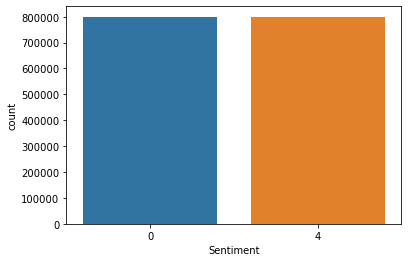

In [4]:
sns.countplot(df.Sentiment)

/Users/hanra/miniforge3/envs/tf25/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

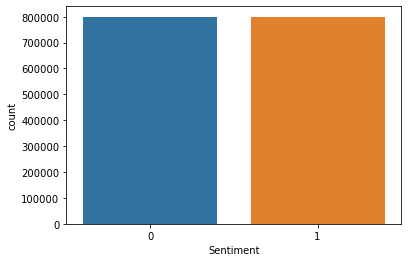

In [5]:
df['Sentiment'] = df.Sentiment.replace(4,1)
sns.countplot(df.Sentiment)

In [6]:
# This is automatically done by bert tokenizer.
# def decontractions(phrase):
#     '''Performs decontractions in the doc'''

#     phrase = re.sub(r"won't", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)
#     phrase = re.sub(r"couldn\'t", "could not", phrase)
#     phrase = re.sub(r"shouldn\'t", "should not", phrase)
#     phrase = re.sub(r"wouldn\'t", "would not", phrase)
#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
        
#     return phrase

In [7]:
import re
from nltk.corpus import stopwords

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")
sw_nltk = stopwords.words('english')

def preprocessing(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    words = [word for word in text.split() if word.lower() not in sw_nltk]
    text = " ".join(words)
    return text.strip().lower()

In [8]:
df['Text'] = df.Text.apply(preprocessing)

In [9]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [10]:
from sklearn.model_selection import train_test_split

train_sent = np.array(df.Text)
train_label = np.array(df.Sentiment)

x_train, x_test, y_train, y_test = train_test_split(train_sent, train_label, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(train_sent, train_label, test_size=0.10, random_state=42)

print("TRAIN size:", len(x_train))
print("VAL size:", len(x_val))
print("TEST size:", len(x_test))

TRAIN size: 1440000
VAL size: 160000
TEST size: 320000


In [11]:
import tensorflow_hub as hub

from tensorflow.keras import layers
import bert
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [12]:
# Hyper Parameters
# 1000, 30, 300 73%
vocab_size = 1000
embedding_dim = 50 
max_length = 300
trunc_type='post'
oov_tok = "<OOV>"

In [13]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = sequence.pad_sequences(training_sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = sequence.pad_sequences(testing_sequences,maxlen=max_length)

val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded = sequence.pad_sequences(val_sequences,maxlen=max_length)

training_label=y_train
testing_label=y_test
val_label=y_val

In [14]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

2022-03-02 23:21:28.898489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-02 23:21:28.898625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [15]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

In [16]:
tokenized_reviews = [tokenize_reviews(review) for review in df.Text]

In [17]:
print(tokenized_reviews[10])

[3500, 3338, 5810, 2103, 1012, 1012, 1012, 4586, 2075]


In [18]:
import random 

reviews = []
sentences = list(df['Text'])
for sen in sentences:
    reviews.append(sen)
    
y = df['Sentiment']

reviews_with_len = [[review, y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]
# Word Vector - Label - length of sequence.
print(reviews_with_len[0])

[[9178, 1011, 22091, 2860, 2860, 1010, 2008, 1005, 1055, 26352, 5017, 1012, 2323, 2050, 2288, 2585, 12385, 2353, 2154, 2009, 1012, 1025, 1040], 0, 23]


In [19]:
random.shuffle(reviews_with_len)

In [20]:
#reviews_with_len.sort(key=lambda x: x[2])
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]
sorted_reviews_labels
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))

In [21]:
BATCH_SIZE = 32 # You can edit here i.e 128
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [22]:
next(iter(batched_dataset))

2022-03-02 23:23:33.984442: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(<tf.Tensor: shape=(32, 34), dtype=int32, numpy=
 array([[ 1048,  2773,  1012, ...,     0,     0,     0],
        [20277,  2480,  2147, ...,     0,     0,     0],
        [ 2296,  7292,  3902, ...,     0,     0,     0],
        ...,
        [ 9178,  2417, 13675, ...,     0,     0,     0],
        [ 9178, 22091,  2860, ...,     0,     0,     0],
        [ 2757,  2066,  2522, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1], dtype=int32)>)

In [23]:
import math

TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [24]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 50)           50000     
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 50,833
Trainable params: 50,833
Non-trainable params: 0
_________________________________________________________________


In [26]:
history=model.fit(training_padded, training_label, epochs=5, 
                  validation_data=(val_padded, val_label))

Epoch 1/5


2022-03-02 23:23:34.297893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45000/45000 [==============================] - ETA: 0s - loss: 0.5304 - accuracy: 0.7306

2022-03-03 09:04:14.270752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45000/45000 [==============================] - 34855s 775ms/step - loss: 0.5304 - accuracy: 0.7306 - val_loss: 0.5160 - val_accuracy: 0.7404
Epoch 2/5
45000/45000 [==============================] - 2741s 61ms/step - loss: 0.5090 - accuracy: 0.7438 - val_loss: 0.5104 - val_accuracy: 0.7427
Epoch 3/5
45000/45000 [==============================] - 2751s 61ms/step - loss: 0.5047 - accuracy: 0.7462 - val_loss: 0.5066 - val_accuracy: 0.7432
Epoch 4/5
45000/45000 [==============================] - 2746s 61ms/step - loss: 0.5023 - accuracy: 0.7481 - val_loss: 0.5024 - val_accuracy: 0.7471
Epoch 5/5
45000/45000 [==============================] - 2752s 61ms/step - loss: 0.5007 - accuracy: 0.7491 - val_loss: 0.4984 - val_accuracy: 0.7506


In [27]:
from keras.models import load_model
model.save('mnist_mlp_model.h5')